## Creating dataset for YOLO training

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from skimage.io import imread # to load images from files
from PIL import Image
import random
import os
import os.path as osp
from tqdm import tqdm
import albumentations as A
import math

In [2]:
def reading_in_bbox_txt_file(bbox_path) :
    bboxes = []
    file = open(bbox_path,'r')
    while True:
        content=file.readline()
        if not content:
            break
        elements = [ float(x) for x in content.strip().split(" ") ]
        bboxes.append(elements)
    file.close()

    return bboxes

def has_bbox_info(bbox_path):
    file = open(bbox_path,'r')
    content=file.readline()
    return True if content else not content

In [3]:
def reading_in_background_image(background_file_names, image_path, bg_width, bg_height_old, bg_height) :

    while True:
        # Find random background image
        file_name = random.choice(background_file_names)
        background_image_path = osp.join(image_path, file_name)

        background = cv2.cvtColor(cv2.imread(background_image_path), cv2.COLOR_BGR2RGB)
        height, width, channels = background.shape

        if width == bg_width and height == bg_height_old:
            background = background[0:bg_height, 0:bg_width]
            return background, file_name
        if width == bg_height_old and height == bg_width:
            background = cv2.rotate(background, cv2.ROTATE_90_CLOCKWISE)
            background = background[0:bg_height, 0:bg_width]
            return background, file_name

def reading_in_random_digit(image_path, file_names, bbox_path) :

    while True:

        file_name = str(random.choice(file_names).split(".")[0])
        digit_image_path = osp.join(image_path, file_name + '.png')
        digit_bbox_path = osp.join(bbox_path, file_name + '.txt')

        if has_bbox_info(digit_bbox_path):
            
            digit = cv2.cvtColor(cv2.imread(digit_image_path), cv2.COLOR_BGR2RGBA)
            digit_bboxes = reading_in_bbox_txt_file(digit_bbox_path)
            
            return digit, digit_bboxes

In [4]:
def erode_digits(digit):
    kernel = np.ones((2, 2), np.uint8) 
    digit = cv2.dilate(digit, kernel, iterations=4)
    return digit


In [5]:

def remove_background(image):
    pixels = image.getdata()
    newData = []
  
    for item in pixels:
        if item[0] <= 255 and item[0] >= 100 and item[1] <= 255 and item[1] >= 100 and item[2] <= 255 and item[2] >= 100: # white background
            newData.append((255, 255, 255, 0))
        else:
            newData.append(item)

    image.putdata(newData)
    return image


In [6]:
def refine_digit(image):
    pixels = image.getdata()
    newData = []
  
    for item in pixels:
        if item[0] <= 255 and item[0] >= 150 and item[1] <= 255 and item[1] >= 150 and item[2] <= 255 and item[2] >= 150: # white background
            newData.append((255, 255, 255, 255))
        else:
            newData.append(item)

    image.putdata(newData)
    return image

In [7]:
def resize_image_transform(image_width, image_height):
    return A.Compose([
        A.Resize(p=1, height=image_height, width=image_width)
    ])

In [8]:
def find_new_digit_bboxes_on_image(digit_bboxes, digit_width, digit_height, xstart, ystart, bg_width, bg_height):
    new_bboxes = []
    labels = []

    for i in range(len(digit_bboxes)):
        bbox = [(xstart + (float(digit_bboxes[i][1]) * digit_width))/bg_width,
                (ystart + (float(digit_bboxes[i][2]) * digit_height))/bg_height,
                (float(digit_bboxes[i][3]) * digit_width)/bg_width,
                (float(digit_bboxes[i][4]) * digit_height)/bg_height
               ]
        labels.append(digit_bboxes[i][0])
        new_bboxes.append(bbox)

    return new_bboxes, labels
    

In [9]:
def save_bboxes_into_txt(path, bboxes, labels):
    with open(path, "w") as file:
        for i in range(len(bboxes)):
            file.write(str(labels[i]) + " " + str(bboxes[i][0]) + " " + str(bboxes[i][1]) + " " + str(bboxes[i][2]) + " " + str(bboxes[i][3]) + "\n")
        file.close()  

## Starting the creation

In [10]:

dataset_path = "../datasets/EMNIST_3digits" 

digits_images_train = "{}/images/train".format(dataset_path)
digits_bboxes_train = "{}/labels/train".format(dataset_path)

digits_images_val = "{}/images/val".format(dataset_path)
digits_bboxes_val = "{}/labels/val".format(dataset_path)

background_train = "../datasets/OpenImages_data_example/train"
background_val = "../datasets/OpenImages_data_example/val"

digits_file_names_train = os.listdir(digits_images_train)
background_file_names_train = os.listdir(background_train)

digits_file_names_val = os.listdir(digits_images_val)
background_file_names_val = os.listdir(background_val)



In [11]:

path = "../datasets/making_YOLO_data"

if not os.path.exists(path):
    os.makedirs(path)

# Path for every model images
images_path_per_model = os.path.join(path, "images")
if not os.path.exists(images_path_per_model):
    os.makedirs(images_path_per_model)
# Path for every model images
labels_path_per_model = os.path.join(path, "labels")
if not os.path.exists(labels_path_per_model):
    os.makedirs(labels_path_per_model)

train_path = os.path.join(images_path_per_model, "train")
if not os.path.exists(train_path):
    os.makedirs(train_path)
test_path = os.path.join(images_path_per_model, "val")
if not os.path.exists(test_path):
    os.makedirs(test_path)

train_path = os.path.join(labels_path_per_model, "train")
if not os.path.exists(train_path):
    os.makedirs(train_path)
test_path = os.path.join(labels_path_per_model, "val")
if not os.path.exists(test_path):
    os.makedirs(test_path)


merged_img_train = "{}/images/train".format(path)
merged_label_train = "{}/labels/train".format(path)

merged_img_val = "{}/images/val".format(path)
merged_label_val = "{}/labels/val".format(path)

In [12]:

digits_img_path = [digits_images_train, digits_images_val]
digits_labels_path = [digits_bboxes_train, digits_bboxes_val]
background_path = [background_train, background_val]
digits_file_names = [digits_file_names_train, digits_file_names_val]
background_file_names = [background_file_names_train, background_file_names_val]
generate_x_images = [100, 10] #[35000, 3500]
merged_image_path = [merged_img_train, merged_img_val]
merged_labels_path = [merged_label_train, merged_label_val]

OpenImg_width = 1024
OpenImg_height_old = 768
OpenImg_height = 576
final_width = 1920
final_height = 1080
digit_resize_width = 480
digit_resize_height = 320
min_width = 150
max_width = 500


for i in range(2):

    for j in tqdm(range(generate_x_images[i])):
    
        background_image, background_image_filename = reading_in_background_image(background_file_names[i], background_path[i], OpenImg_width, OpenImg_height_old, OpenImg_height)
        digit, digit_bboxes = reading_in_random_digit(digits_img_path[i], digits_file_names[i], digits_labels_path[i])

        # Resize background
        image_resize = resize_image_transform(final_width, final_height) # Image ratio 16:9
        background_resized = image_resize(image=np.array(background_image))
        background_image = Image.fromarray(np.uint8(background_resized['image'])).convert('RGBA')

        # Resize digit
        image_resize = resize_image_transform(digit_resize_width, digit_resize_height) # Image ratio 16:9
        digit_resized = np.uint8(image_resize(image=np.array(digit))['image'])

        # Refine digits
        digit = Image.fromarray(digit_resized, 'RGBA')
        digit = refine_digit(digit)
        digit = erode_digits(np.array(digit))

        # Remove digit image background
        digit = Image.fromarray(digit, 'RGBA')
        output = remove_background(digit)

        # Randomly generate the new digit image size
        bg_width, bg_height = background_image.size
        max_digit_width_height = min(bg_width, bg_height)
        digit_width_new = random.randint(min_width, max_width) # Subtracting 30 so the image would not be right on the edge (for perspective transformation)
        digit_height_new = int(digit_width_new/(output.size[0]/output.size[1]))
    
        output = output.resize((digit_width_new, digit_height_new), Image.BICUBIC) # Resize digit
        
        xstart = random.randint(0, bg_width - digit_width_new) # Randomly generate the x-coordinate for the digit image
        ystart = random.randint(0, bg_height - digit_height_new) # Randomly generate the y-coordinate for the digit image
        
        background_image.paste(output, (xstart, ystart), output)

        #image = background_image.convert('RGB')
        digit_bboxes_on_image, digit_labels = find_new_digit_bboxes_on_image(digit_bboxes, digit_width_new, digit_height_new, xstart, ystart, bg_width, bg_height)

        
        # Save image
        image_path = osp.join(merged_image_path[i], '{}_{}.png'.format(j, background_image_filename.split(".")[0]))
        #output_image = Image.fromarray(np.uint8(transformed_image)).convert('RGBA')
        background_image.save(image_path, format='png')
    
        # Save lables
        labels_path = osp.join(merged_labels_path[i],  '{}_{}.txt'.format(j, background_image_filename.split(".")[0]))
        save_bboxes_into_txt(labels_path, digit_bboxes_on_image, digit_labels)


100%|████████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


## Visualization

In [19]:
def show_image_with_bounding_box (xcentre, ycentre, width, heigth, image_width, image_height):

    xmin = (xcentre - width/2) * image_width
    ymin = (ycentre - heigth/2) * image_height
    xmax = (xcentre + width/2) * image_width
    ymax = (ycentre + heigth/2) * image_height

    plt.plot([xmin, xmin], [ymin, ymax], '-', color = 'red' ) # Left edge
    plt.plot([xmax, xmax], [ymin, ymax], '-', color = 'red') # Right edge
    plt.plot([xmin, xmax], [ymin, ymin], '-', color = 'red') # Top edge
    plt.plot([xmin, xmax], [ymax, ymax], '-', color = 'red') # Bottom edge

../datasets/making_YOLO_data/images/train/53_0a7f4d9a0ccb9afe.png


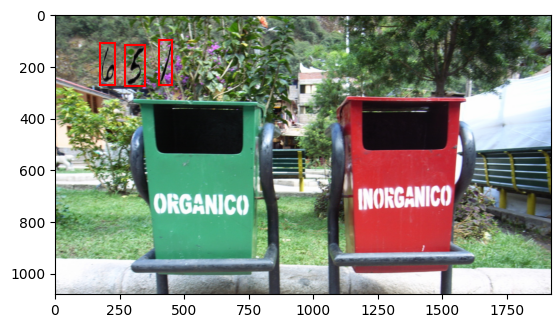

In [20]:

file_name = os.listdir(merged_img_train)[1]
image_path = osp.join(merged_img_train, file_name)
image_label_path = osp.join(merged_label_train, '{}.txt'.format(file_name.split(".")[0]))

print(image_path)

image = imread(image_path)
image_labels = reading_in_bbox_txt_file(image_label_path)


plt.imshow(image)

for i in range(len(image_labels)):
    show_image_with_bounding_box(image_labels[i][1], image_labels[i][2], image_labels[i][3], image_labels[i][4], image.shape[1], image.shape[0])

plt.axis('on')
plt.show()